# Measure X and K using qiskit.pulse

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
import qiskit.tools.jupyter
from scipy.optimize import curve_fit
from scipy.special import factorial

## Load backend

In [3]:
account_provider = qk.IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [4]:
provider = qk.IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_armonk')
config = backend.configuration()
device = qk.pulse.PulseChannelSpec.from_backend(backend)
backend

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)
/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

## Setup variables

In [5]:
fr_range = config.meas_lo_range[0]  # measurement frequency range (GHz)
fr = sum(fr_range) / 2  # centre of measurement frequency range (GHz)
fr_delta = 5.0e-3  # how far on either side of the centre frequency to search (in GHz)
fr_steps = np.linspace(fr - fr_delta, fr + fr_delta, 100)  # step size for frequency search

In [6]:
def poisson(k, lamb):
    """ Poisson function (not used to fit the frequency responses). """
    return (lamb**k / factorial(k)) * np.exp(-lamb)

In [7]:
def gaussian(x, a, mu, sigma):
    """ Gaussian function (used to fit the frequency responses). """
    return a * np.exp(-(x - mu)**2 / (2. * sigma**2))

## Run measurements on |0> and |1> across a range of frequencies

In [8]:
# TODO

In [9]:
def fake_readings(f_centre, x_steps, noise=1e-6):
    """ Generate fake readings. """
    return gaussian(x_steps, 10., f_centre, 0.5) + noise * np.random.uniform(size=x_steps.shape)

In [10]:
f0 = fake_readings(fr - fr_delta / 2, fr_steps)
f1 = fake_readings(fr + fr_delta / 2, fr_steps)

## Plot measurement response as a function of frequency

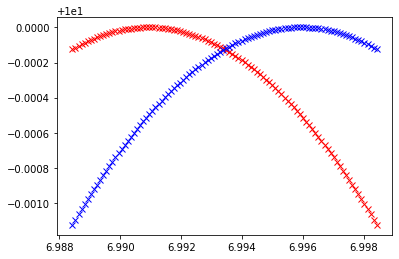

In [11]:
plt.plot(fr_steps, f0, 'rx')
plt.plot(fr_steps, f1, 'bx')

## Fit Poisson distribution to frequency responses

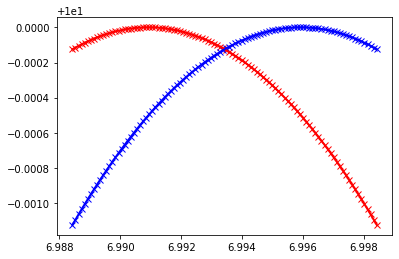

In [12]:
initial_fit = [1., fr, 1.]

f0_fit, f0_cov_matrix = curve_fit(gaussian, fr_steps, f0, p0=initial_fit)
f0_a, f0_centre, f0_sigma = f0_fit

f1_fit, f1_cov_matrix = curve_fit(gaussian, fr_steps, f1, p0=initial_fit)
f1_a, f1_centre, f1_sigma = f1_fit

plt.plot(fr_steps, f0, 'rx')
plt.plot(fr_steps, f1, 'bx')
plt.plot(fr_steps, gaussian(fr_steps, *f0_fit), 'r-', lw=2)
plt.plot(fr_steps, gaussian(fr_steps, *f1_fit), 'b-', lw=2)

In [13]:
f0_centre, f1_centre

(6.990928108865618, 6.9959275356301145)

## Determine X and K from fits

In [14]:
X = (f1_centre - f0_centre) / 2
X

0.002499713382248192

In [15]:
avg_sigma = np.abs((f1_sigma + f0_sigma) / 2)
K = 2 * (2 * np.log(2)) ** 0.5 * avg_sigma  # averge FWHM
K

1.1773422526957464